# Udacity MLND capstone: [dogs vs cats](https://github.com/nd009/capstone/tree/master/dog_vs_cat)

## <font color=blue>Transfer learning</font>

Bin Zhu @ 04.05.2018

使用深度学习方法识别一张图片是猫还是狗。

- 输入：一张彩色图片
- 输出：是猫还是狗
- 可选输出：猫狗面部坐标，猫狗身体mask


Reference：

1. [手把手教你如何在Kaggle猫狗大战冲到Top2% - 杨培文](https://zhuanlan.zhihu.com/p/25978105)

### 1、数据预处理

In [1]:
import os
import shutil
import h5py
import cv2
import numpy as np

from keras.models import Model
from keras.layers import Input, Lambda, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import InceptionResNetV2, inception_resnet_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop

train_list = os.listdir('data/train/')
train_dog = list(filter(lambda x:x[:3] == 'dog', train_list))
train_cat = list(filter(lambda x:x[:3] == 'cat', train_list))

if not os.path.exists('data/train1'):
    os.mkdir('data/train1')
    os.mkdir('data/train1/dog')
    os.mkdir('data/train1/cat')
    for filename in train_dog:
#         os.symlink('data/train/' + filename, 'data/train1/dog/' + filename)
        shutil.copy('data/train/' + filename, 'data/train1/dog/' + filename)
    for filename in train_cat:
#         os.symlink('data/train/' + filename, 'data/train1/cat/' + filename)
        shutil.copy('data/train/' + filename, 'data/train1/cat/' + filename)

test_list = os.listdir('data/test/')
if not os.path.exists('data/test1'):
    os.mkdir('data/test1')
    os.mkdir('data/test1/test')
    for filename in test_list:
#         os.symlink('data/test/' + filename, 'data/test1/test/' + filename)
        shutil.copy('data/test/' + filename, 'data/test1/test/' + filename)

d:\python3\tfgpu\dl+\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [31]:
##########################
#       remove out       #
#    out获取在另一文件   #
##########################

out = [[252, 372, 503, 1741, 2150, 2433, 2520, 2939, 3216, 3658, 3672, 3731, 3868, 4308, 4338, 4688, 4852, 5071, 5347, 5351, 5418, 6429, 6442, 6655, 6699, 7377, 7487, 7564, 7599, 7920, 7968, 8456, 8470, 9090, 9171, 9444, 9596, 10029, 10270, 10365, 10712, 11184, 11231, 11544, 12227, 12272, 12424], [1194, 1259, 1308, 1773, 1895, 2422, 2614, 3889, 4367, 5604, 6475, 6725, 8736, 9188, 9517, 10161, 10190, 10237, 10801, 11299, 12376]]

if not os.path.exists('data/train2'):
    os.mkdir('data/train2')
    os.mkdir('data/train2/dog')
    os.mkdir('data/train2/cat')
    for filename in train_dog:
        if int(filename.split('.')[1]) in out[1]: 
            pass
        else:
            shutil.copy('data/train/' + filename, 'data/train2/dog/' + filename)
    for filename in train_cat:
        if int(filename.split('.')[1]) in out[0]: 
            pass
        else:
            shutil.copy('data/train/' + filename, 'data/train2/cat/' + filename)

In [34]:
len(os.listdir('data/train2/dog')) + len(os.listdir('data/train2/cat')) + len(out[0]) + len(out[1])

25000

### 2 训练特征向量

In [2]:
if not os.path.exists('h5'):
    os.mkdir('h5/')

def write_vec(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    
    input_tensor = Input((height, width, 3))
    x = input_tensor
    
    if lambda_func: 
        x = Lambda(lambda_func)(x)
        
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("data/train1", image_size, shuffle=False, 
                                              batch_size=16)
#     train_generator = gen.flow_from_directory("data/train2", image_size, shuffle=False, 
#                                               batch_size=16)
    test_generator = gen.flow_from_directory("data/test1", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)
    print('a')
    train = model.predict_generator(train_generator)
    print('b')
    test = model.predict_generator(test_generator)
    
    with h5py.File("h5/vec_%s_pure.h5" % MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

write_vec(InceptionResNetV2, (299, 299), inception_resnet_v2.preprocess_input)
# write_vec(MobileNet, (224, 224), mobilenet.preprocess_input)
# write_vec(DenseNet201, (224, 224), densenet.preprocess_input)

Found 24932 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
a
b


### 3 载入特征向量

- VGG16
- VGG19
- ResNet50
- InceptionV3
- Xception
- Inception_ResNet_V2
- Inception_ResNet_V2_pure

In [2]:
import h5py
import numpy as np
from sklearn.utils import shuffle

np.random.seed(2018)

def read_data(model_name):
    with h5py.File("h5/gap_%s.h5" % model_name, 'r') as h:
        X_train = np.array(h['train'])
        X_test = np.array(h['test'])
        y_train = np.array(h['label'])

    X_train, y_train = shuffle(X_train, y_train)
    
    return X_train, y_train, X_test

X_train, y_train, X_test = read_data('Xception')

### 4 模型构建

In [3]:
np.random.seed(2018)

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

### 5 训练

In [4]:
from keras.callbacks import TensorBoard

log_filepath = 'H:/tmp/keras/single/adadelta'
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0, write_graph=True, write_images=True)

In [5]:
from time import time

start = time()
# model.fit(X_train, y_train, batch_size=512, epochs=30, validation_split=0.2, callbacks=[tb_cb])
model.fit(X_train, y_train, batch_size=512, epochs=23, validation_split=0.2)
print('fit time: {}s'.format(time() - start))

Train on 20000 samples, validate on 5000 samples
Epoch 1/23
20000/20000 [==============================] - 3s 134us/step - loss: 0.0906 - acc: 0.9732 - val_loss: 0.0289 - val_acc: 0.9932
Epoch 2/23
20000/20000 [==============================] - 0s 18us/step - loss: 0.0262 - acc: 0.9929 - val_loss: 0.0253 - val_acc: 0.9924
Epoch 3/23
20000/20000 [==============================] - 0s 20us/step - loss: 0.0211 - acc: 0.9939 - val_loss: 0.0287 - val_acc: 0.9910
Epoch 4/23
20000/20000 [==============================] - 0s 19us/step - loss: 0.0202 - acc: 0.9940 - val_loss: 0.0208 - val_acc: 0.9944
Epoch 5/23
20000/20000 [==============================] - 0s 18us/step - loss: 0.0181 - acc: 0.9944 - val_loss: 0.0216 - val_acc: 0.9936
Epoch 6/23
20000/20000 [==============================] - 0s 18us/step - loss: 0.0163 - acc: 0.9949 - val_loss: 0.0200 - val_acc: 0.9940
Epoch 7/23
20000/20000 [==============================] - 0s 19us/step - loss: 0.0165 - acc: 0.9950 - val_loss: 0.0196 - val_acc

| model(remove out) | dropout+dense | batch_size | epochs_total | epoch_vl_0.0180 | epoch_vl_best | best_val_loss | val_acc| loss | acc  | total_time | score (no clip)|
|:|
| InceptionResNetV2 |       0.5+1('s') |  64 | 30   | 3 |  7  | 0.0160 | 0.9966 | 0.0180 | 0.9959 | 46.16s
| InceptionResNetV2 |       0.5+1('s') | 128 | 30   | 4 |  8  | 0.0157 | 0.9966 | 0.0166 | 0.9955 | 27.47s
| InceptionResNetV2 |       0.5+1('s') | 256 | 30   | 6 | 12  | 0.0157 | 0.9968 | 0.0163 | 0.9958 | 18.21s
| InceptionResNetV2 |       0.5+1('s') | 512 | 30   | 9 | 18  | 0.0159 | 0.9964 | 0.0163 | 0.9960 | 14.93s
| InceptionResNetV2 |  64('r')+0.5+1('s') | 128 | 30   | 3 |  4  | 0.0164 | 0.9964 | 0.0147 | 0.9965 | 26.74s
| InceptionResNetV2 |  64('r')+0.5+1('s') | 256 | 30   | 2 |  4  | 0.0155 | 0.9966 | 0.0164 | 0.9961 | 19.43s | 0.03871(0.04816)
| InceptionResNetV2 |  64('r')+0.5+1('s') | 512 | 30   | 3 |  8  | 0.0155 | 0.9962 | 0.0145 | 0.9963 | 13.74s
| InceptionResNetV2 |  64('r')+0.5+1('s') |1024 | 30   | 5 | 18  | 0.0158 | 0.9962 | 0.0128 | 0.9971 | 10.93s
| InceptionResNetV2 | 128('r')+0.5+1('s') |  64 | 30   | 1 |  1  | 0.0157 | 0.9964 | 0.0402 | 0.9874 | 48.20s
| InceptionResNetV2 | 128('r')+0.5+1('s') | 128 | 30   | 3 |  4  | 0.0155 | 0.9964 | 0.0135 | 0.9965 | 28.68s
| InceptionResNetV2 | 128('r')+0.5+1('s') | 256 | 30   | 1 |  4  | 0.0160 | 0.9962 | 0.0151 | 0.9961 | 19.52s
| InceptionResNetV2 | 128('r')+0.5+1('s') | 512 | 30   | 3 |  4  | 0.0157 | 0.9962 | 0.0169 | 0.9956 | 13.78s
| InceptionResNetV2 | 128('r')+0.5+1('s') |1024 | 30   | 4 | 12  | 0.0156 | 0.9964 | 0.0123 | 0.9971 | 11.65s
| InceptionResNetV2 | 256('r')+0.5+1('s') |  64 | 30   | 1 |  1  | 0.0172 | 0.9960 | 0.0369 | 0.9890 | 54.01s
| InceptionResNetV2 | 256('r')+0.5+1('s') | 128 | 30   | 1 |  3  | 0.0159 | 0.9962 | 0.0152 | 0.9960 | 29.72s
| InceptionResNetV2 | 256('r')+0.5+1('s') | 256 | 30   | 3 |  4  | 0.0158 | 0.9958 | 0.0137 | 0.9962 | 18.95s
| InceptionResNetV2 | 256('r')+0.5+1('s') | 512 | 30   | 3 |  6  | 0.0159 | 0.9964 | 0.0145 | 0.9963 | 14.55s
| InceptionResNetV2 | 256('r')+0.5+1('s') |1024 | 30   | 4 |  8  | 0.0161 | 0.9964 | 0.0148 | 0.9963 | 11.91s

| model | dropout+dense | batch_size | epochs_total | epoch_vl_0.0180 | epoch_vl_best | best_val_loss | val_acc| loss | acc  | total_time | score (no clip)|
|:|
| InceptionResNetV2 |       0.5+1('s') | 256 |30(60) | - |  40 | 0.0181 | 0.9952 | 0.0170 | 0.9956 | 19.82s
| InceptionResNetV2 |  64('r')+0.5+1('s') | 128 | 30   | 6 |  12 | 0.0165 | 0.9958 | 0.0102 | 0.9969 | 27.80s
| InceptionResNetV2 |  64('r')+0.5+1('s') | 256 |30(60) | 9 |  29 | 0.0154 | 0.9950 | 0.0063 | 0.9982 | 19.63s | 0.03745(0.05507)
| InceptionResNetV2 |  64('r')+0.5+1('s') | 512 | 30   |11 |  19 | 0.0156 | 0.9952 | 0.0100 | 0.9972 | 14.06s
| InceptionResNetV2 | 128('r')+0.5+1('s') | 128 | 30   | 4 |  8  | 0.0159 | 0.9958 | 0.0116 | 0.9969 | 27.72s
| InceptionResNetV2 | 128('r')+0.5+1('s') | 256 | 30   | 9 |  20 | 0.0155 | 0.9952 | 0.0074 | 0.9981 | 19.68s
| InceptionResNetV2 | 128('r')+0.5+1('s') | 512 | 30   |12 |  24 | 0.0156 | 0.9952 | 0.0077 | 0.9978 | 13.58s
| InceptionResNetV2 | 256('r')+0.5+1('s') |  64 | 30   | 7 |  12 | 0.0166 | 0.9952 | 0.0100 | 0.9970 | 52.38s
| InceptionResNetV2 | 256('r')+0.5+1('s') | 128 | 30   | 7 |  12 | 0.0160 | 0.9956 | 0.0084 | 0.9974 | 26.80s
| InceptionResNetV2 | 256('r')+0.5+1('s') | 256 | 30   | 4 |  20 | 0.0160 | 0.9956 | 0.0064 | 0.9980 | 19.21s
| InceptionResNetV2 | 256('r')+0.5+1('s') | 512 | 30   |11 |  25 | 0.0159 | 0.9952 | 0.0063 | 0.9981 | 14.00s
| InceptionResNetV2 | 256('r')+0.5+1('s') |1024 |30(60) |15 |  40 | 0.0161 | 0.9956 | 0.0061 | 0.9986 | 12.01s

| model | dropout+dense | batch_size | epochs_total | epoch_vl_0.0200 | epoch_vl_best | best_val_loss | val_acc| loss | acc  | total_time | test_score (no clip)|
|:|
| Xception | 0.5+1('s') |  64 | 30 | 16 | 28 | 0.0194 | 0.9940 | 0.0147 | 0.9955 | 33.42s
| Xception | 0.5+1('s') | 128 | 30 | 17 | 26 | 0.0193 | 0.9938 | 0.0157 | 0.9944 | 23.64s
| Xception | 0.5+1('s') | 256 | 30 | 19 | 28 | 0.0196 | 0.9938 | 0.0150 | 0.9952 |  20.30s
| Xception | 32('r')+0.5+1('s') | 128 | 30 | - |  8 | 0.0202 | 0.9928 | 0.0092 | 0.9972 | 28.11s
| Xception | 32('r')+0.5+1('s') | 256 | 30 | 19 | 19 | 0.0194 | 0.9944 | 0.0096 | 0.9974 | 19.40s
| Xception | 32('r')+0.5+1('s') | 512 | 30 | 14 | 19 | 0.0198 | 0.9944 | 0.0153 | 0.9963 | 16.33s
| Xception |128('r')+0.5+1('s') |  64 | 30 |  4 |  4 | 0.0190 | 0.9944 | 0.0151 | 0.9956 | 89.65s
| Xception |128('r')+0.5+1('s') | 128 | 30 |  6 |  6 | 0.0184 | 0.9942 | 0.0086 | 0.9976 | 54.04s
| Xception |128('r')+0.5+1('s') | 256 | 30 |  1 |  1 | 0.0220 | 0.9948 | 0.0015 | 0.9996 | 35.97s
| Xception | 64('r')+0.5+1('s') | 128 | 30 |  6 | 18 | 0.0189 | 0.9944 | 0.0061 | 0.9985 | 38.46s
| Xception |256('r')+0.5+1('s') | 128 | 30 |  4 | 14 | 0.0185 | 0.9946 | 0.0049 | 0.9986 | 97.35s
| Xception |256('r')+0.5+1('s') | 256 | 30 |  4 | 18 | 0.0183 | 0.9944 | 0.0056 | 0.9983 | 59.68s
| Xception |256('r')+0.5+1('s') | 512 | 30 |  4 | 23 | 0.0182 | 0.9944 | 0.0073 | 0.9979 | 47.36s | 0.04213 (0.05868)|
| Xception |256('r')+0.5+1('s') |1024 | 50 | 12 | 35 | 0.0186 | 0.9942 | 0.0077 | 0.9979 | 67.75s
| Xception |512('r')+0.5+1('s') | 128 | 30 |  4 |  4 | 0.0190 | 0.9942 | 0.0141 | 0.9955 | 170.00s

| model | optimizer | dropout+dense | batch_size | epochs_total | epoch_vl_0.0200 | epoch_vl_best | best_val_loss | val_acc | total_time | test_score (no clip)|
|:|
| Xception | SGD(0.1,0.9,0.9)| 256('r')+0.5+1('s') |256 |700   |  - |700 | 0.0302 | 0.9922 |    -  |  |
| Xception | SGD(0.1,0.9,0.1)| 256('r')+0.5+1('s') |256 |700   |  - |700 | 0.0230 | 0.9946 |    -  |  |
| Xception | SGD(0.1,0.9, 0) | 256('r')+0.5+1('s') |256 |30    |  6 | 12 | 0.0185 | 0.9942 |    -  |  |
| Xception | SGD(0.2,0.9, 0) | 256('r')+0.5+1('s') |256 |30    |  3 |  9 | 0.0185 | 0.9942 |    -  |  |
| Xception | SGD(0.01,0.9,0) | 256('r')+0.5+1('s') |256 |30(100)| 18 | 55 | 0.0189 | 0.9942 | 21.88s |  |
| Xception | SGD(0.1,0.7, 0) | 256('r')+0.5+1('s') |256 |30    |  6 | 14 | 0.0184 | 0.9940 | 21.45s | 0.04115(0.05502) |
| Xception | SGD(0.1,0.5, 0) | 256('r')+0.5+1('s' )|256 |30(60) |  8 | 25 | 0.0186 | 0.9944 | 21.40s |  |
| Xception | adagrad  |       0.5+1('s') | 128 | 30(300)  | 41 |233 | 0.0190 | 0.9942 | 30.03s |  |
| Xception | adagrad  | 256('r')+0.5+1('s') |  16 | 30     |  4 |  6 | 0.0186 | 0.9942 |187.52s |  |
| Xception | adagrad  | 256('r')+0.5+1('s') |  32 | 30     |  4 |  6 | 0.0181 | 0.9940 | 98.37s | 0.04172(0.05625) |
| Xception | adagrad  | 256('r')+0.5+1('s') |  64 | 30     |  4 |  9 | 0.0185 | 0.9940 | 54.06s |  |
| Xception | adagrad  | 256('r')+0.5+1('s') | 128 | 30     |  4 | 14 | 0.0188 | 0.9946 | 31.04s |  |
| Xception | adagrad  | 256('r')+0.5+1('s') | 256 | 30     |  6 | 12 | 0.0191 | 0.9938 | 21.32s |  |
| Xception | adadelta |       0.5+1('s') | 128 | 30     | 17 | 26 | 0.0193 | 0.9938 | 30.31s |  |
| Xception | adadelta | 256('r')+0.5+1('s') | 128 | 30     |  7 | 14 | 0.0184 | 0.9946 | 33.64s |  |
| Xception | adadelta | 256('r')+0.5+1('s') | 256 | 30     |  4 | 18 | 0.0183 | 0.9942 | 21.46s |  |
| Xception | adadelta | 256('r')+0.5+1('s') | 512 | 30(100)  |  6 | 22 | 0.0182 | 0.9942 | 16.09s | 0.04201(0.05814) |
| Xception | adadelta | 256('r')+0.5+1('s') | 1024 | 100    | 12 | 48 | 0.0186 | 0.9944 | 29.74s |  |
| Xception | RMSprop(0.001) | 256('r')+0.5+1('s') | 512 |30    |  4 | 12 | 0.0193 | 0.9948 | 12.53s |  |
| Xception | RMSprop(0.0001) |       0.5+1('s') | 128|30(300)|118 |205 | 0.0197 | 0.9940 | 31.44s |  |
| Xception | RMSprop(0.0001) | 256('r')+0.5+1('s') | 128|30(60) |  7 | 18 | 0.0190 | 0.9938 | 33.31s |  |
| Xception | RMSprop(0.0001) | 256('r')+0.5+1('s') | 256|30(60) |  8 | 25 | 0.0184 | 0.9940 | 16.44s |  |
| Xception | RMSprop(0.0001) | 256('r')+0.5+1('s') | 512|30(60) | 12 | 33 | 0.0183 | 0.9938 | 16.36s | 0.04199(0.05613) |
| Xception | RMSprop(0.0001) | 256('r')+0.5+1('s') |1024|30(90) | 15 | 56 | 0.0184 | 0.9942 |  9.07s |  |
| Xception | RMSprop(0.00001)| 256('r')+0.5+1('s') |128 |30(240)| 69 |187 | 0.0193 | 0.9938 | 32.76s |  |
| Xception | RMSprop(0.00001)| 256('r')+0.5+1('s') |256 |30(240)| 74 |187 | 0.0189 | 0.9936 | 17.31s |  |
| Xception | RMSprop(0.00001)| 256('r')+0.5+1('s') |512 |30    |  - |  1 | 0.0274 | 0.9956 | 11.61s |  |
| Xception | adam    |       0.5+1('s') | 128 |30(60)   | 12 | 26 | 0.0188 | 0.9940 | 29.96s |  |
| Xception | adam    | 256('r')+0.5+1('s') | 128 | 30     |  3 |  6 | 0.0189 | 0.9946 | 32.19s |  |
| Xception | adam    | 256('r')+0.5+1('s') | 256 | 30     |  6 |  7 | 0.0184 | 0.9946 | 20.26s | 0.04224(0.05926) |
| Xception | adam    | 256('r')+0.5+1('s') | 512 | 30     |  6 | 14 | 0.0187 | 0.9942 | 15.33s |  |

| model | dropout+dense | batch_size | epochs_total | epoch_vl_0.0230 | epoch_vl_best | best_val_loss | val_acc| loss | acc  | total_time | test_score |
|:|
| InceptionV3 | 0.5+1('s') |  64 | 30 | 11 | 20 | 0.0223 | 0.9922 | 0.0162 | 0.9945 | 32.64s
| InceptionV3 | 0.5+1('s') | 128 | 30 |  2 | 14 | 0.0222 | 0.9924 | 0.0180 | 0.9942 | 25.11s
| InceptionV3 | 0.5+1('s') | 256 | 30 | 11 | 20 | 0.0226 | 0.9926 | 0.0174 | 0.9938 |  19.48s
| InceptionV3 | 32('r')+0.5+1('s') | 128 | 30 |  8 |  8 | 0.0230 | 0.9928 | 0.0092 | 0.9972 | 26.42s
| InceptionV3 | 32('r')+0.5+1('s') | 256 | 30 |  4 |  6 | 0.0222 | 0.9930 | 0.0141 | 0.9954 | 19.77s | 0.04755 |
| InceptionV3 | 32('r')+0.5+1('s') | 256 | 30 |  8 | 11 | 0.0224 | 0.9924 | 0.0130 | 0.9963 | 15.98s
| InceptionV3 |128('r')+0.5+1('s') | 128 | 30 |  - |  4 | 0.0245 | 0.9922 | 0.0126 | 0.9960 | 52.18s
| InceptionV3 |128('r')+0.5+1('s') | 256 | 30 |  - |  6 | 0.0242 | 0.9928 | 0.0103 | 0.9970 | 27.65s
| InceptionV3 | 64('r')+0.5+1('s') | 128 | 30 |  - |  2 | 0.0233 | 0.9918 | 0.0215 | 0.9932 | 36.80s
| InceptionV3 | 16('r')+0.5+1('s') | 128 | 30 |  - |  4 | 0.0264 | 0.9918 | 0.0246 | 0.9929 | 36.80s

| model | dropout+dense | batch_size | epochs_total | epoch_vl_0.0600 | epoch_vl_best | best_val_loss | val_acc| loss | acc  | total_time | test_score |
|:|
| ResNet50 | 0.5+1('s') |  32 | 30 |  6 | 11 | 0.0587 | 0.9770 | 0.0687 | 0.9750 | 52.30s
| ResNet50 | 0.5+1('s') |  64 | 30 |  6 |  6 | 0.0574 | 0.9776 | 0.0694 | 0.9734 | 32.23s
| ResNet50 | 0.5+1('s') | 128 | 30 |  6 | 20 | 0.0577 | 0.9766 | 0.0665 | 0.9741 | 23.50s
| ResNet50 | 0.5+1('s') | 256 | 30 | 12 | 21 | 0.0581 | 0.9760 | 0.0618 | 0.9751 | 18.79s
| ResNet50 | 0.5+1('s') | 512 | 30 | 17 | 28 | 0.0582 | 0.9752 | 0.0614 | 0.9752 | 17.48s
| ResNet50 | 0.5+1('s') | 1024| 30 | 21 | 28 | 0.0584 | 0.9752 | 0.0629 | 0.9748 | 15.15s
| ResNet50 |  32('r')+0.5+1('s') |  128| 30 |  4 |  5 | 0.0557 | 0.9780 | 0.0569 | 0.9795 | 26.85s
| ResNet50 |  32('r')+0.5+1('s') | 1024| 30 | 10 | 25 | 0.0560 | 0.9764 | 0.0485 | 0.9818 | 12.88s
| ResNet50 |  64('r')+0.5+1('s') |  128| 30 |  4 |  5 | 0.0567 | 0.9774 | 0.0574 | 0.9778 | 34.36s
| ResNet50 | 128('r')+0.5+1('s') | 128| 30 |  4 |  4 | 0.0562 | 0.9770 | 0.0552 | 0.9784 | 53.48s
| ResNet50 | 128('r')+0.5+1('s') | 256| 30 |  8 | 19 | 0.0542 | 0.9782 | 0.0178 | 0.9936 | 35.91s
| ResNet50 | 128('r')+0.5+1('s') | 512| 30 |  4 | 19 | 0.0539 | 0.9778 | 0.0259 | 0.9897 | 27.58s
| ResNet50 | 128('r')+0.5+1('s') |1024| 30(60) |  10 |  28 | 0.0530 | 0.9802 | 0.0311 | 0.9885 | 23.27s
| ResNet50 | 256('r')+0.5+1('s') |1024| 30 |  5 | 20 | 0.0519 | 0.9788 | 0.0365 | 0.9859 | 39.85s
| ResNet50 | 256('r')+0.5+1('s') |2048| 60 |  9 | 36 | 0.0527 | 0.9784 | 0.0373 | 0.9852 | -
| ResNet50 | 512('r')+0.5+1('s') | 512| 30 |  4 | 15 | 0.0539 | 0.9780 | 0.0270 | 0.9909 | 83.41s
| ResNet50 | 512('r')+0.5+1('s') |1024| 30 |  8 | 24 | 0.0515 | 0.9784 | 0.0201 | 0.9946 | 67.21s | 0.07089
| ResNet50 |1024('r')+0.5+1('s') |1024| 30 |  5 | 18 | 0.0520 | 0.9792 | 0.0274 | 0.9916 |124.31s

| model | dropout+dense | batch_size | epochs_total | epoch_vl_0.0800 | epoch_vl_best | best_val_loss | val_acc| loss | acc  | total_time |
|:|
| VGG19 | 0.5+1('s') |  64 | 30 |  6 | 14 | 0.0737 | 0.9724 | 0.1332 | 0.9504 | 23.15s
| VGG19 | 0.5+1('s') | 128 | 30 |  8 | 14 | 0.0733 | 0.9728 | 0.1296 | 0.9513 | 13.71s
| VGG19 | 0.5+1('s') | 256 | 30 |  9 | 14 | 0.0727 | 0.9748 | 0.1287 | 0.9498 |  8.55s
| VGG19 | 32('r')+0.5+1('s') | 128 | 30 |  4 |  6 | 0.0732 | 0.9740 | 0.0724 | 0.9727 | 15.21s
| VGG19 | 32('r')+0.5+1('s') | 256 | 30 |  5 |  6 | 0.0729 | 0.9742 | 0.0804 | 0.9697 | 10.49s

| model | dropout+dense | batch_size | epochs_total | epoch_vl_0.0800 | epoch_vl_best | best_val_loss | val_acc| loss | acc  | total_time |
|:|
| VGG16 | 0.5+1('s') |  64 | 30 |  8 | 23 | 0.0759 | 0.9704 | 0.1414 | 0.9470 | 22.10s
| VGG16 | 0.5+1('s') | 128 | 30 |  8 | 25 | 0.0750 | 0.9712 | 0.1345 | 0.9474 | 12.65s
| VGG16 | 0.5+1('s') | 256 | 30 | 11 | 23 | 0.0767 | 0.9692 | 0.1338 | 0.9490 |  9.04s
| VGG16 | 32('r')+0.5+1('s') | 128 | 30 |  4 |  8 | 0.0750 | 0.9708 | 0.0694 | 0.9741 | 16.14s
| VGG16 | 32('r')+0.5+1('s') | 256 | 30 |  8 |  8 | 0.0756 | 0.9712 | 0.0775 | 0.9699 | 10.13s

### 6 模型结构可视化

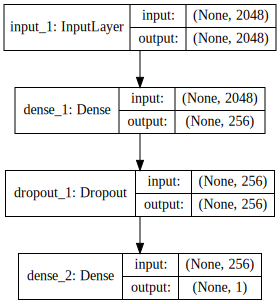

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 7 预测并保存结果

In [7]:
import pandas as pd

y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

if not os.path.exists('submission'):
    os.mkdir('submission/')

df = pd.read_csv("data/sample_submission.csv")

for i, fname in enumerate(os.listdir('data/test/test')):
    df.set_value(int(fname.split('.')[0]) - 1, 'label', y_pred[i])

df.to_csv('submission/pred_Xcep.csv', index=None)
df.head(10)

12500/12500 [==============================] - 4s 352us/step


d:\python3\tfgpu\dl+\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

### 8 回测训练集

这一步本来用于筛选异常值，事实证明是不可行的

In [5]:
def read_train_data(model_name):
    with h5py.File("h5/vec_%s.h5" % model_name, 'r') as h:
        X_train = np.array(h['train'])
        y_train = np.array(h['label'])
    
    return X_train, y_train

X_train, y_train = read_train_data('Xception')

pred_train = model.predict(X_train, verbose=1)

25000/25000 [==============================] - 1s 26us/step


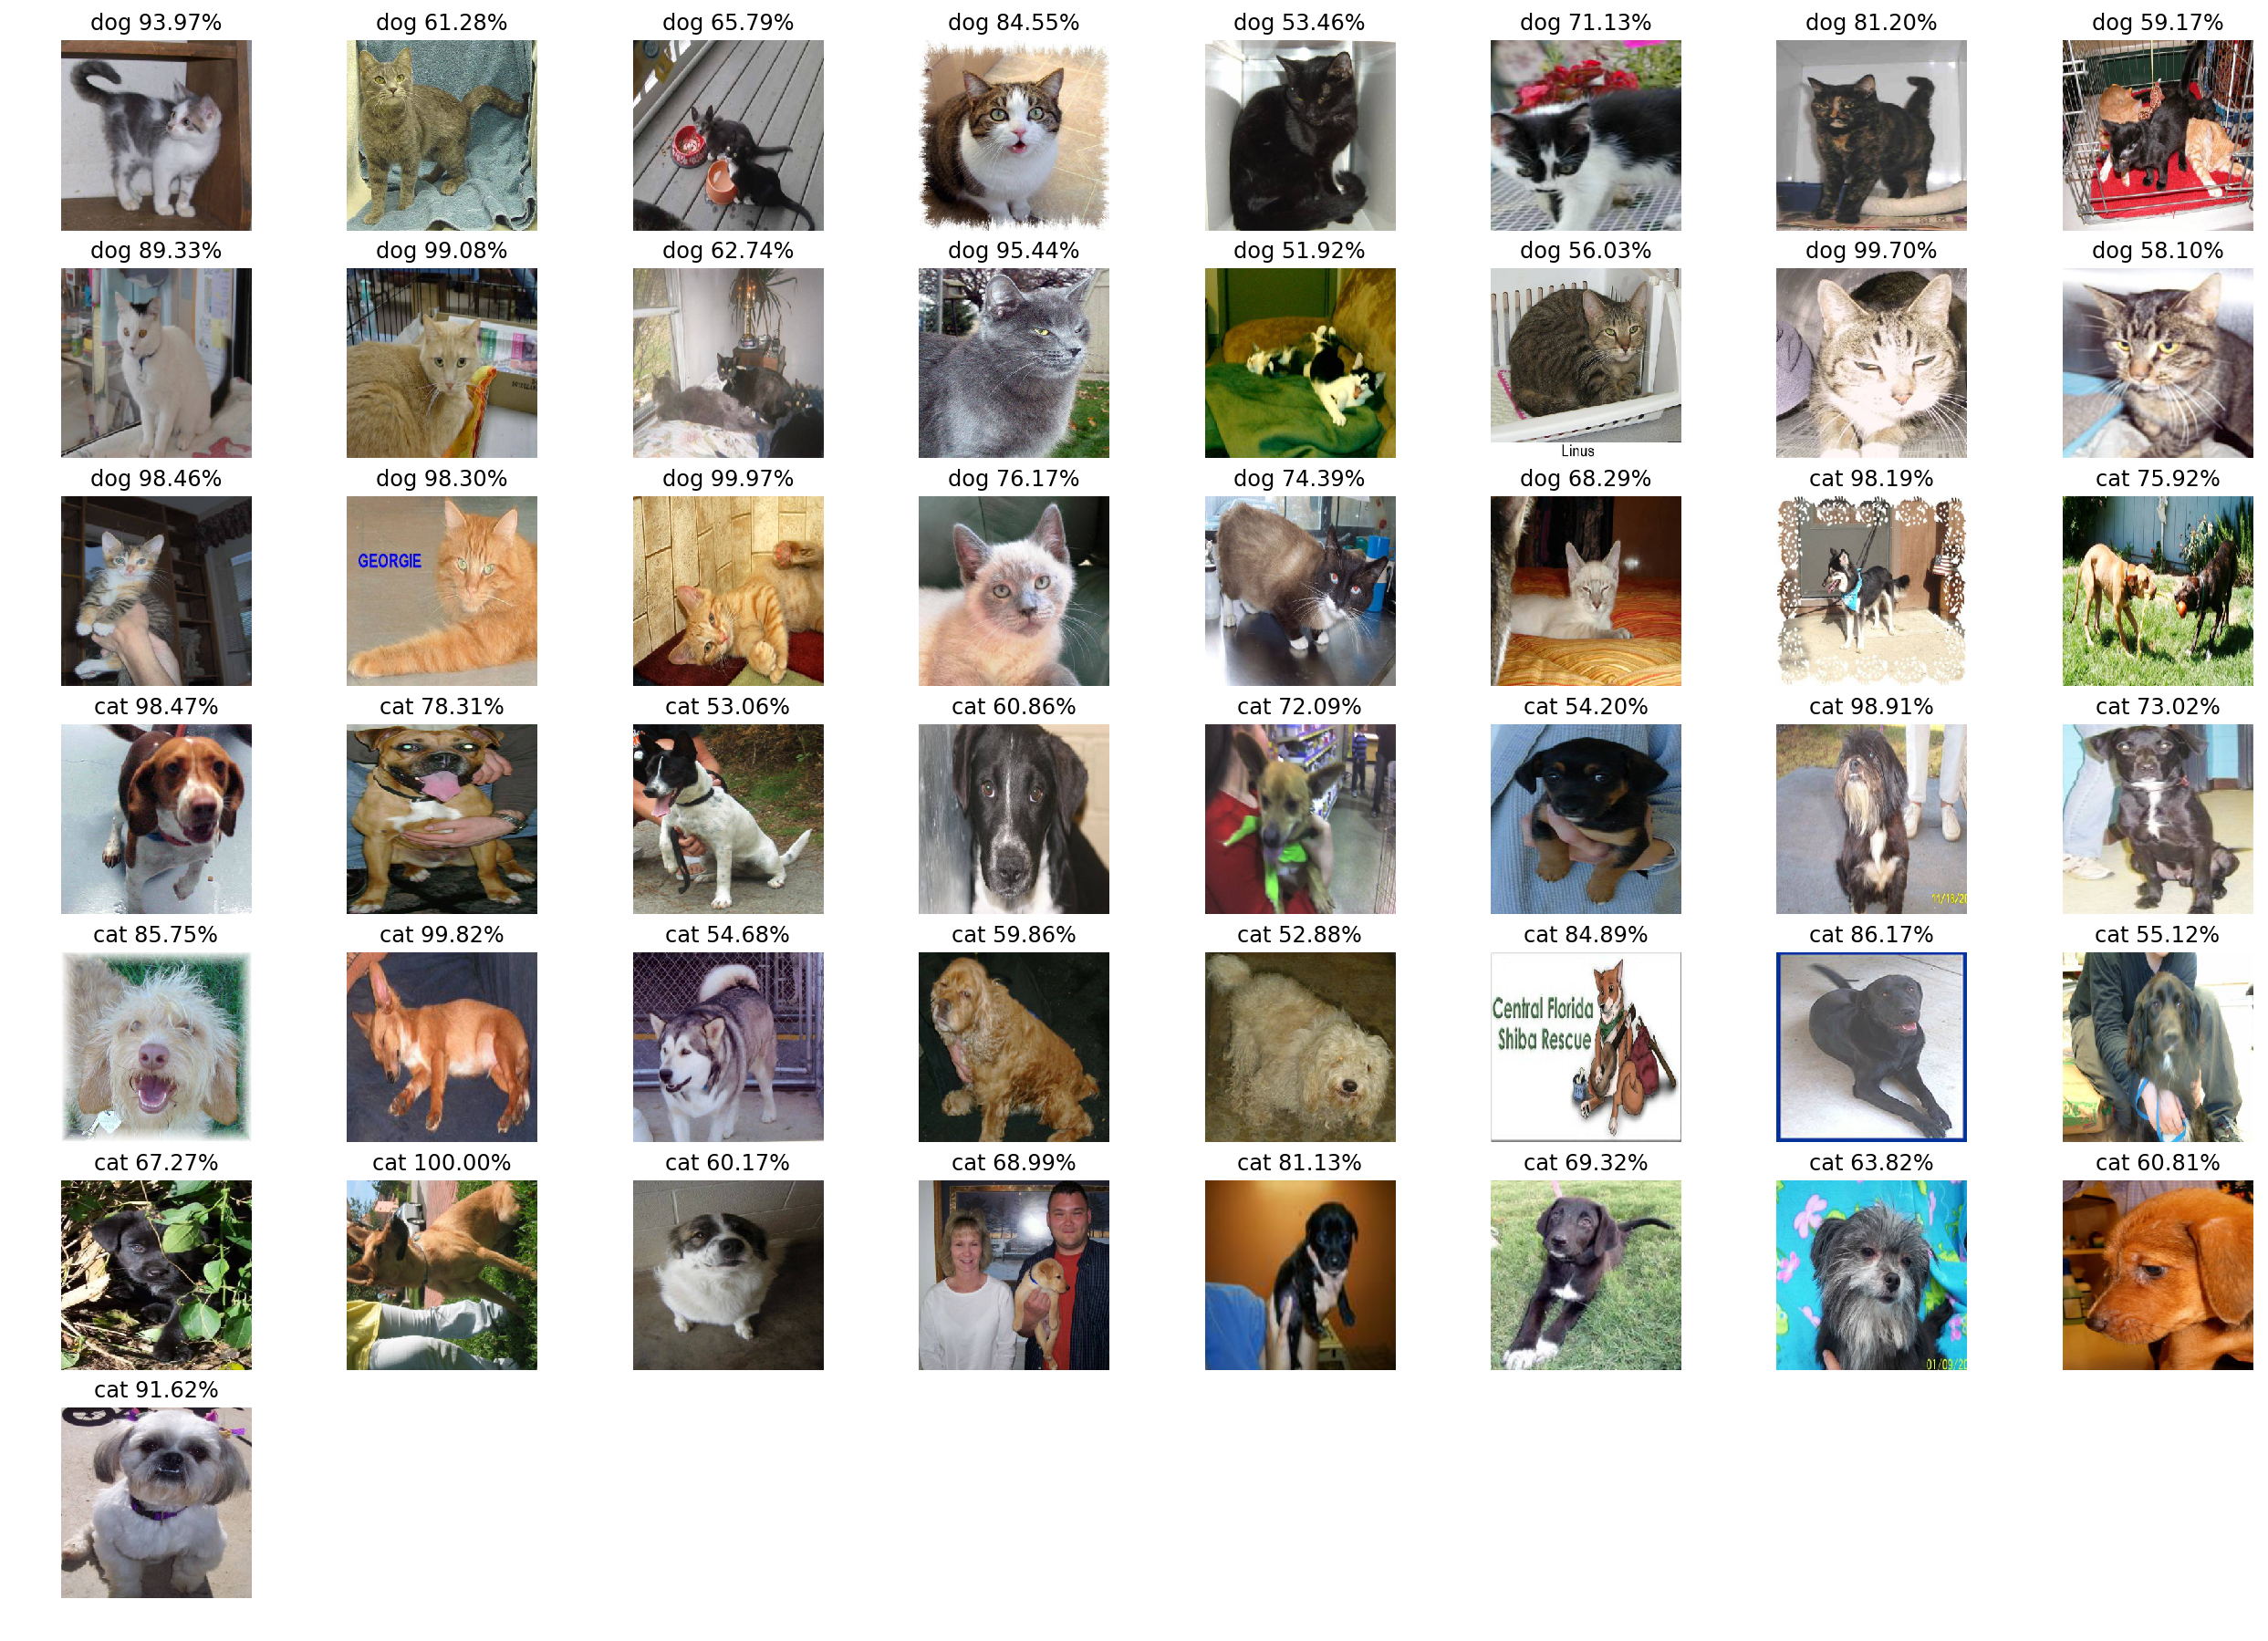

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

IMG_SHAPE = (299, 299)
plt.figure(figsize=(22,18))
n = 0
out = []
for i in range(25000):
    if n > 63: break
    if abs(pred_train[i][0] - y_train[i]) >= 0.5:
        out.append(i)
        if i < 12500:
            img = cv2.resize(cv2.imread('data/train1/cat/cat.%d.jpg' % i), IMG_SHAPE)
        else:
            img = cv2.resize(cv2.imread('data/train1/dog/dog.%d.jpg' % (i-12500)), IMG_SHAPE)
        plt.subplot(8, 8, n+1)
        if pred_train[i] < 0.5:
            plt.title('cat %.2f%%' % (100 - 100 * pred_train[i][0]))
        else:
            plt.title('dog %.2f%%' % (100 * pred_train[i][0]))
        plt.axis('off')
        plt.imshow(img[:, :, ::-1])
        n += 1